In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
import numpy as np


pre = Precision()
re = Recall()
acc = BinaryAccuracy()

Found 18748 images belonging to 118 classes.
Found 590 images belonging to 118 classes.
Found 590 images belonging to 118 classes.
Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 200s 333ms/step - accuracy: 0.0168 - loss: 4.6810 - val_accuracy: 0.0868 - val_loss: 3.8471
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.0938 - loss: 1.8978 - val_accuracy: 0.1429 - val_loss: 1.7850
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 182s 308ms/step - accuracy: 0.0954 - loss: 3.9173 - val_accuracy: 0.2049 - val_loss: 3.1359
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.2500 - loss: 1.6659 - val_accuracy: 0.1429 - val_loss: 1.3475
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 187s 318ms/step - accuracy: 0.1585 - loss: 3.5078 - val_accuracy: 0.3333 - val_loss: 2.6165
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - accuracy: 0.0625 - loss: 1.5675 - val_accuracy: 0.2143 - val_loss: 1.5248
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 188s 319ms/step - accuracy: 0.2134 - 

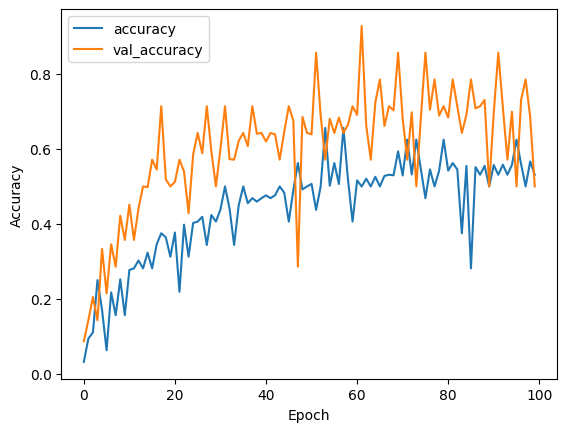

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define the paths to the train, valid, and test folders
train_data_dir = '../P4/train'
valid_data_dir = '../P4/valid'
test_data_dir = '../P4/test'

# Define image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Generate training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Define the CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,  # Increase the number of epochs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
    # callbacks=[early_stopping]  # Add early stopping callback
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
model.save('bird_classifier_model.h5')


In [ ]:
for batch in test_generator:
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {pre.result()},Recall: {re.result()}, Accuracy: {acc.result()}')

In [55]:
bird_species = list(test_generator.class_indices.keys())


In [60]:
loaded_model = tf.keras.models.load_model('bird_classifier_model.h5')

sample_image_path = '../P4/test/BURCHELLS COURSER/5.jpg'


def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Resize the image to the target size
    image = cv2.resize(image, (128, 128))
    # Convert the image to float32 and normalize its pixel values to the range [0, 1]
    # image = tf.image.convert_image_dtype(image, tf.float32)
    # Expand the dimensions to create a batch of size 1
    image = np.expand_dims(image, axis=0)
    return image


In [63]:

sample_image_path = '../P4/test/BUFFLEHEAD/5.jpg'

image = preprocess_image(sample_image_path)

image.shape
predictions = loaded_model.predict(preprocess_image(sample_image_path))
predicted_class_index = tf.argmax(predictions, axis=1)[0]
predicted_bird_species = bird_species[predicted_class_index]
predicted_bird_species


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


'BANDED PITA'

In [ ]:
loaded_model = tf.keras.models.load_model('bird_classifier_model.h5')

sample_image_path = '../P4/test/BARN OWL/5.jpg'
img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = loaded_model.predict(img_array)
predicted_class_index = tf.argmax(predictions, axis=1)[0]
predicted_bird_species = bird_species[predicted_class_index]
plt.imshow(img)
plt.title(predicted_bird_species)
plt.show()